In this notebook we use the `./final/dataset.npz` dataset to train multiple ML models to create a surrogate models. The comparison between models will be presented in the next notebook.

During training process dataset is split into train, test and validate sets of sizes `700000`, `150000` and `150000`.

List of tested methods (with links to used implementations):
1. [Neural Networks](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
2. Linear regression model:
    1. [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) L1 and L2 regularization combined
3. Decistion Trees models:
    1. [Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)
    2. [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)
    3. [Random Forrest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
    4. [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
4. [k-nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

For each ML method we use [Optuna](https://optuna.readthedocs.io) to find best performing set of parameters.

In [2]:
RUN_ITERATIONS_PERCENT = 100  # runs only X percent of iterations. pick small number to test if notebook is working fine
LOWER_LIMIT = -7
PCA_COMPONENTS = 12

In [3]:
# Loading dataset
import numpy as np
import os
from pathlib import Path

Path("../final/ml_models").mkdir(parents=True, exist_ok=True)
Path("../final/pca").mkdir(parents=True, exist_ok=True)

input_and_output = np.load("../final/dataset.npz")
inputs  = input_and_output["inputs"].astype(np.float64)
outputs = input_and_output["outputs"].astype(np.float64)

print(f"inputs shape: {inputs.shape} dtype: {inputs.dtype}, outputs shape: {outputs.shape}, dtype: {outputs.dtype}")
dataset_size = inputs.shape[0]

inputs shape: (1000000, 11) dtype: float64, outputs shape: (1000000, 200), dtype: float64


In [4]:
# In this problem we are interrested in order of magnitude rather than absolute value of the tumour size.
# To train the models output is first transformed with log_10. When the tumour size is smaller than 10^-7 L, 
# there is no way to find it, so we can limit the lower bound of tumour size with 10^-7

def output_transform(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    zeros_in_output = x <= 0
    x[zeros_in_output] = 1
    y = np.log10(x)
    y[zeros_in_output] = LOWER_LIMIT
    y[y < LOWER_LIMIT] = LOWER_LIMIT
    return y
    
def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs < LOWER_LIMIT
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

def apply_size_limit(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    x[x < LOWER_LIMIT] = LOWER_LIMIT
    return x

def apply_absolute_size_limit(outputs: np.array) -> np.array:
    limit = 10 ** LOWER_LIMIT
    x = np.copy(outputs)
    x[x < limit] = 0
    return x

test_output = np.array([10**(-8), 10**(-5), 10**(-10), 10**(-9),1,2,10,0.0])

print(f"test output {test_output}")
print(f"transformed output: {output_transform(test_output)}")
print(f"original output is untouched after transform: {test_output}")
print(f"transformed and untransformed output: {output_untransform(output_transform(test_output))}")

outputs_order_of_magnitude = output_transform(outputs)

test output [1.e-08 1.e-05 1.e-10 1.e-09 1.e+00 2.e+00 1.e+01 0.e+00]
transformed output: [-7.      -5.      -7.      -7.       0.       0.30103  1.      -7.     ]
original output is untouched after transform: [1.e-08 1.e-05 1.e-10 1.e-09 1.e+00 2.e+00 1.e+01 0.e+00]
transformed and untransformed output: [1.e-07 1.e-05 1.e-07 1.e-07 1.e+00 2.e+00 1.e+01 1.e-07]


In [5]:
# Input data has an extra column with all ones - that we get rid of before training the model

def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

input_without_treatment = drop_treatment(inputs)

In [6]:
# Splitting dataset into train, test, validate subsets
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)

X_train = input_without_treatment[:train_size, :]
Y_train = outputs_order_of_magnitude[:train_size, :]
Y_train_absolute = apply_absolute_size_limit(outputs[:train_size, :])
print(f"train sizes: {X_train.shape}, {Y_train.shape}")
X_test = input_without_treatment[train_size:(train_size + test_size), :]
Y_test = outputs_order_of_magnitude[train_size:(train_size + test_size), :]
Y_test_absolute = apply_absolute_size_limit(outputs[train_size:(train_size + test_size), :])
print(f"test sizes: {X_test.shape}, {Y_test.shape}")

train sizes: (700000, 10), (700000, 200)
test sizes: (150000, 10), (150000, 200)


In [7]:
# scaling inputs
from sklearn.preprocessing import MinMaxScaler
import pickle
from pathlib import Path


LOGNORMAL_PARAMETERS = (1, 2)

class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res

scaler_path = Path(f"../final/scaler.pickle")
scaler = None
if scaler_path.exists():
    with scaler_path.open("rb") as scaler_file:
        scaler = pickle.load(scaler_file)
else:
    scaler = CustomScaler().fit(X_train)
    with scaler_path.open("wb") as opened_file:
        pickle.dump(scaler, opened_file)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

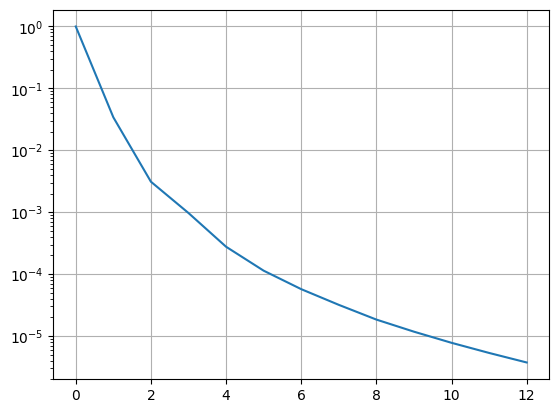

[1.0, 0.03410384435084102, 0.003106897801798618, 0.000969674948484091, 0.0002765983052562249, 0.00011354673170349986, 5.709448516057331e-05, 3.185061047704866e-05, 1.8415046228805752e-05, 1.1742919633497516e-05, 7.759383996475301e-06, 5.323364604445493e-06, 3.734028192154632e-06]


In [8]:
# applying pca to outputs
from sklearn.decomposition import PCA

pca_path = Path(f"../final/pca/{PCA_COMPONENTS}_{LOWER_LIMIT}.pickle")

if pca_path.exists():
    with pca_path.open("rb") as opened_file:
        pca = pickle.load(opened_file)
    Y_train_pca = pca.transform(Y_train)
else: 
    pca = PCA(n_components=PCA_COMPONENTS)
    Y_train_pca = pca.fit_transform(Y_train)
    with pca_path.open("wb") as opened_file:
        pickle.dump(pca, opened_file)

from functools import reduce
unexplained_variance = list(reduce(lambda a, b: a + [a[-1] - b], pca.explained_variance_ratio_, [1.0]))

from matplotlib import pyplot as plt
plt.yscale('log')
plt.grid()
plt.plot(range(0, len(unexplained_variance)), unexplained_variance)
plt.show()
print(unexplained_variance)

In [9]:
# Example of limitting running time of the loop by scheduling an sigalrm and setting a handler for it.

import optuna
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import psutil
import os
import signal

class TimeoutError(Exception):
    pass

def timeout_handler(*args):
    raise TimeoutError(f"timeout {args}")

def keyboard_interrupt_handler(*args):
    os.kill(os.getpid(), signal.SIGINT)
    
signal.signal(signal.SIGALRM, timeout_handler)

try:
    signal.alarm(2)
    time.sleep(1)
    signal.alarm(0)
    print(f"1. no exception")
except TimeoutError as e:
    print(f"1. message: {e}") 
except KeyboardInterrupt as e:
    print(f"1. KEYBOARD: {e}") 

try:
    signal.alarm(2)
    time.sleep(5)
    signal.alarm(0)
    print(f"2. no exception")
except TimeoutError as e:
    print(f"2. message: {e}")
except KeyboardInterrupt as e:
    print(f"2. keyboard: {e}") 

1. no exception
2. message: timeout (14, <frame at 0x125aa6820, file '/var/folders/jg/gsbj6mcn3ldd9z2krrny7lx80000gq/T/ipykernel_50764/692385139.py', line 35, code <module>>)


In [17]:
import time
from sklearn.metrics import mean_squared_error
from cpuinfo import get_cpu_info
import json


def save_best_model(model, trial, training_time):
    global X_test_scaled, Y_test_absolute, Y_test, Y_train_absolute, X_train_scaled, Y_train, Y_train_absolute, pca, PCA_COMPONENTS, LOWER_LIMIT
    try: 
        best_value = trial.study.best_value
    except: 
        best_value = float('inf')
    
    start_time = time.time()
    test_result_orders   = apply_size_limit(pca.inverse_transform(model.predict(X_test_scaled)))
    test_evaluation_s = int(time.time() - start_time)
    error_test_orders    = mean_squared_error(Y_test,          test_result_orders)
    error = error_test_orders
    
    if error < best_value:
        test_result_absolute = output_untransform(test_result_orders)
        error_test_absolute  = mean_squared_error(Y_test_absolute, test_result_absolute)

        start_time = time.time()
        train_result_orders   = apply_size_limit(pca.inverse_transform(model.predict(X_train_scaled)))
        train_evaluation_s = int(time.time() - start_time)
        train_result_absolute = output_untransform(train_result_orders)
        error_train_orders    = mean_squared_error(Y_train,          train_result_orders)
        error_train_absolute  = mean_squared_error(Y_train_absolute, train_result_absolute)
        
        print(f"Updating {trial.study.study_name}.pickle")
        with Path(f"../final/ml_models/{trial.study.study_name}.pickle").open("wb") as opened_file:
            pickle.dump(model, opened_file)
        info_filename = f"../final/ml_models/{trial.study.study_name}_metadata.json"
        with Path(info_filename).open('w') as opened_file:
            info = json.dumps({
                "cpu_info": {key: get_cpu_info()[key] for key in ["arch", "bits", "brand_raw", "count", "l2_cache_size"]},
                "pca_components": PCA_COMPONENTS,
                "pca_unexplained_variance_ratio": reduce(lambda a, b: a - b, pca.explained_variance_ratio_, 1.0),
                "tumour_lower_size_limit_l": 10 ** LOWER_LIMIT,
                "tumour_lower_size_limit_log10_l": LOWER_LIMIT,
                "model_params": trial.user_attrs["model_params"],
                "test_dataset": "[700000:850000] of ../final/dataset.npz",
                "test_error_orders_of_magnitude": error_test_orders,
                "test_error_absolute": error_test_absolute,
                "train_dataset": f"[:700000] of ../final/dataset.npz",
                "train_error_orders_of_magnitude": error_train_orders,
                "train_error_absolute": error_train_absolute,
                "training_time_s": int(training_time),
                "train_evaluation_s": train_evaluation_s,
                "test_evaluation_s": test_evaluation_s
            }, sort_keys=True, indent=4)
            print(f"saving info to file: {info_filename} {info}")
            opened_file.write(info)  
    return error

In [10]:
# Hyperparameter optimization for neural network

from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits

common_params={
    "tol": 3e-6,
    "n_iter_no_change": 5,
    "random_state": 42,
    "warm_start": False,
    "batch_size": 10000,
    "max_iter": 1000,
    "learning_rate": "constant"
}

def objective(trial):
    global common_params
    
    model_params = {
        **common_params,
        "alpha": trial.suggest_float("alpha", 0.0001, 1.0, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 0.0001, 0.1, log=True),
        "hidden_layer_sizes": [
            trial.suggest_int(f"layer1/3", 600, 1000, step=200),
            trial.suggest_int(f"layer2/3", 200, 500, step=50),
            trial.suggest_int(f"layer3/3", 10, 30, step=5),
        ]
    }
    trial.set_user_attr("model_params", model_params)
    model = MLPRegressor(**trial.user_attrs["model_params"])
    
    try:
        start_time = time.time()
        signal.alarm(1200)
        with threadpool_limits(limits=8, user_api='blas'):
            model.fit(X_train_scaled, Y_train_pca)
            signal.alarm(0)
            error = save_best_model(model, trial, time.time() - start_time) 
    except TimeoutError:
        raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(study_name="MLPRegressor", storage='sqlite:///../final/optuna.db', load_if_exists=True)
trials_due = 30 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
if trials_due > 0:
    previous_handler = signal.signal(signal.SIGALRM, keyboard_interrupt_handler)
    study.optimize(objective, n_trials=trials_due)
    signal.signal(signal.SIGALRM, previous_handler)
    
print(f"model: {study.study_name} test dataset error: {study.best_value} best_params: {study.best_params}")

[I 2023-05-12 12:45:06,990] A new study created in RDB with name: MLPRegressor
/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Updating MLPRegressor.pickle


[I 2023-05-12 13:05:50,898] Trial 0 finished with value: 0.0008359497511514066 and parameters: {'alpha': 0.1376519897117858, 'learning_rate_init': 0.0005063065739222942, 'layer1/3': 800, 'layer2/3': 250, 'layer3/3': 20}. Best is trial 0 with value: 0.0008359497511514066.


saving info to file: ../final/ml_models/MLPRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.1376519897117858,
        "batch_size": 10000,
        "hidden_layer_sizes": [
            800,
            250,
            20
        ],
        "learning_rate": "constant",
        "learning_rate_init": 0.0005063065739222942,
        "max_iter": 1000,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 3e-06,
        "warm_start": false
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 8.2623109175623e-08,
    "test_error_orders_of_magnitude": 0.000841513030757973,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../final/

[I 2023-05-12 13:19:55,149] Trial 1 finished with value: 0.0006222190227717262 and parameters: {'alpha': 0.002277703831970186, 'learning_rate_init': 0.020358694596904526, 'layer1/3': 1000, 'layer2/3': 350, 'layer3/3': 15}. Best is trial 1 with value: 0.0006222190227717262.


saving info to file: ../final/ml_models/MLPRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.002277703831970186,
        "batch_size": 10000,
        "hidden_layer_sizes": [
            1000,
            350,
            15
        ],
        "learning_rate": "constant",
        "learning_rate_init": 0.020358694596904526,
        "max_iter": 1000,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 3e-06,
        "warm_start": false
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 6.692848573353866e-08,
    "test_error_orders_of_magnitude": 0.0006285323391665227,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../f

/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2023-05-12 13:40:11,749] Trial 2 finished with value: 0.0017940493551197162 and parameters: {'alpha': 0.2528175813985304, 'learning_rate_init': 0.00041958212827314086, 'layer1/3': 1000, 'layer2/3': 500, 'layer3/3': 30}. Best is trial 1 with value: 0.0006222190227717262.
[I 2023-05-12 13:47:42,927] Trial 3 finished with value: 0.005353923834893775 and parameters: {'alpha': 0.2161155816968103, 'learning_rate_init': 0.03306961416835714, 'layer1/3': 1000, 'layer2/3': 300, 'layer3/3': 30}. Best is trial 1 with value: 0.0006222190227717262.
/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2023-05-1

Updating MLPRegressor.pickle


[I 2023-05-12 14:41:09,493] Trial 7 finished with value: 0.00041684346051810544 and parameters: {'alpha': 0.0028475847425103993, 'learning_rate_init': 0.01211056983916587, 'layer1/3': 600, 'layer2/3': 500, 'layer3/3': 30}. Best is trial 7 with value: 0.00041684346051810544.


saving info to file: ../final/ml_models/MLPRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.0028475847425103993,
        "batch_size": 10000,
        "hidden_layer_sizes": [
            600,
            500,
            30
        ],
        "learning_rate": "constant",
        "learning_rate_init": 0.01211056983916587,
        "max_iter": 1000,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 3e-06,
        "warm_start": false
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 8.917762550256553e-08,
    "test_error_orders_of_magnitude": 0.0004286470566544347,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../fi

/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2023-05-12 15:01:18,795] Trial 8 finished with value: 0.0013861904658972312 and parameters: {'alpha': 0.0014064320323262877, 'learning_rate_init': 0.00014664301032319693, 'layer1/3': 600, 'layer2/3': 200, 'layer3/3': 15}. Best is trial 7 with value: 0.00041684346051810544.
/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2023-05-12 15:21:31,504] Trial 9 finished with value: 0.001201041615852048 and parameters: {'alpha': 0.0007003452814208196, 'learning_rate_init': 0.00030855985567603017, 'layer1/3': 1000, 'layer2/3': 250, 'layer3/3': 25}. Best is trial 7 with value: 0.00041684346051810544.
/U

Updating MLPRegressor.pickle


[I 2023-05-12 16:24:29,606] Trial 13 finished with value: 0.0003981560458779711 and parameters: {'alpha': 0.0022565359986494254, 'learning_rate_init': 0.0026137859666033486, 'layer1/3': 800, 'layer2/3': 450, 'layer3/3': 10}. Best is trial 13 with value: 0.0003981560458779711.


saving info to file: ../final/ml_models/MLPRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.0022565359986494254,
        "batch_size": 10000,
        "hidden_layer_sizes": [
            800,
            450,
            10
        ],
        "learning_rate": "constant",
        "learning_rate_init": 0.0026137859666033486,
        "max_iter": 1000,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 3e-06,
        "warm_start": false
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 4.9374995385397204e-08,
    "test_error_orders_of_magnitude": 0.00040955619561074954,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of .

/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2023-05-12 16:44:43,448] Trial 14 finished with value: 0.0005258371993019056 and parameters: {'alpha': 0.000520593847678171, 'learning_rate_init': 0.0017175126183259504, 'layer1/3': 800, 'layer2/3': 450, 'layer3/3': 10}. Best is trial 13 with value: 0.0003981560458779711.
[I 2023-05-12 17:01:41,917] Trial 15 finished with value: 0.00041616782506736 and parameters: {'alpha': 0.026320181628335243, 'learning_rate_init': 0.00312613981723405, 'layer1/3': 600, 'layer2/3': 450, 'layer3/3': 30}. Best is trial 13 with value: 0.0003981560458779711.
[I 2023-05-12 17:15:34,320] Trial 16 finished with value: 0.0006180551814547283 and parameters: {'alpha': 0.03056077414044872, 'learning_rate_init': 0.001842575815222663, 'layer1/3': 800, 'layer2/3': 450, 'layer3/3': 25}. Best is 

Updating MLPRegressor.pickle


[I 2023-05-12 19:12:05,475] Trial 25 finished with value: 0.00038769427035646574 and parameters: {'alpha': 0.0026769899723754474, 'learning_rate_init': 0.00743883296612615, 'layer1/3': 600, 'layer2/3': 450, 'layer3/3': 25}. Best is trial 25 with value: 0.00038769427035646574.


saving info to file: ../final/ml_models/MLPRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.0026769899723754474,
        "batch_size": 10000,
        "hidden_layer_sizes": [
            600,
            450,
            25
        ],
        "learning_rate": "constant",
        "learning_rate_init": 0.00743883296612615,
        "max_iter": 1000,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 3e-06,
        "warm_start": false
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 4.4354804349120286e-08,
    "test_error_orders_of_magnitude": 0.00040117971509611073,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../

[I 2023-05-12 19:22:37,848] Trial 26 finished with value: 0.0011828275044458978 and parameters: {'alpha': 0.008041322508226898, 'learning_rate_init': 0.00737318992379914, 'layer1/3': 800, 'layer2/3': 400, 'layer3/3': 25}. Best is trial 25 with value: 0.00038769427035646574.
/Users/tpawlowski/Documents/qsp_emulation/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2023-05-12 19:42:50,240] Trial 27 finished with value: 0.0021381081721606326 and parameters: {'alpha': 0.022514300032934163, 'learning_rate_init': 0.0010402676307290698, 'layer1/3': 600, 'layer2/3': 450, 'layer3/3': 20}. Best is trial 25 with value: 0.00038769427035646574.


Updating MLPRegressor.pickle


[I 2023-05-12 19:57:33,282] Trial 28 finished with value: 0.00032407374371184105 and parameters: {'alpha': 0.05516912918533483, 'learning_rate_init': 0.002525665247383591, 'layer1/3': 800, 'layer2/3': 350, 'layer3/3': 25}. Best is trial 28 with value: 0.00032407374371184105.


saving info to file: ../final/ml_models/MLPRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.05516912918533483,
        "batch_size": 10000,
        "hidden_layer_sizes": [
            800,
            350,
            25
        ],
        "learning_rate": "constant",
        "learning_rate_init": 0.002525665247383591,
        "max_iter": 1000,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 3e-06,
        "warm_start": false
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 3.9993338245405815e-08,
    "test_error_orders_of_magnitude": 0.0003338552571607778,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../fi

[I 2023-05-12 20:09:36,486] Trial 29 finished with value: 0.0006298468996209759 and parameters: {'alpha': 0.04550635814716267, 'learning_rate_init': 0.002516931794810958, 'layer1/3': 800, 'layer2/3': 350, 'layer3/3': 20}. Best is trial 28 with value: 0.00032407374371184105.


model: MLPRegressor test dataset error: 0.00032407374371184105 best_params: {'alpha': 0.05516912918533483, 'layer1/3': 800, 'layer2/3': 350, 'layer3/3': 25, 'learning_rate_init': 0.002525665247383591}


In [11]:
# Linear regression with combined L1 and L2 priors as regularizer
from sklearn.linear_model import ElasticNet

MAX_POLYNOMIAL_DEGREE = 3
common_params = {
    "random_state": 42,
    "tol": 1e-5,
    "max_iter": 100000
}

for polynomial_degree in range(1, MAX_POLYNOMIAL_DEGREE + 1):
    def objective(trial):
        global common_params, polynomial_degree

        trial.set_user_attr("model_params", {
            **common_params,
            "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
            "alpha": trial.suggest_float("alpha", 0.00001, 1.0, log=True),
            "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False])
        })

        trial.set_user_attr("polynomial degree", polynomial_degree)

        model = make_pipeline(
            PolynomialFeatures(trial.user_attrs["polynomial degree"]),
            ElasticNet(**trial.user_attrs["model_params"])
        )

        try:
            start_time = time.time()
            signal.alarm(polynomial_degree * 400)
            model.fit(X_train_scaled, Y_train_pca)
            signal.alarm(0)
            error = save_best_model(model, trial, time.time() - start_time)
        except TimeoutError:
            raise optuna.exceptions.TrialPruned()
        return error

    study = optuna.create_study(study_name=f"ElasticNet_Poly{polynomial_degree}", storage='sqlite:///../final/optuna.db', load_if_exists=True)
    trials_due = 30 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
    if trials_due > 0:
        study.optimize(objective, n_trials=trials_due)

[I 2023-05-12 20:09:36,573] A new study created in RDB with name: ElasticNet_Poly1


Updating ElasticNet_Poly1.pickle


[I 2023-05-12 20:09:56,389] Trial 0 finished with value: 0.2510663649371343 and parameters: {'l1_ratio': 0.672831054372039, 'alpha': 0.01196468454618732, 'fit_intercept': False}. Best is trial 0 with value: 0.2510663649371343.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.01196468454618732,
        "fit_intercept": false,
        "l1_ratio": 0.672831054372039,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.0009326219632040749,
    "test_error_orders_of_magnitude": 0.2520514915014436,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.0011595735214815278,
    "train_error_orders_of_magnitude": 0.2510663649371343,
    "train_evaluation_s": 2,
    "training_time_s": 1,
    "tumour_lo

[I 2023-05-12 20:10:15,927] Trial 1 finished with value: 0.24983390200112154 and parameters: {'l1_ratio': 0.8527481736946612, 'alpha': 0.007740944325237095, 'fit_intercept': False}. Best is trial 1 with value: 0.24983390200112154.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.007740944325237095,
        "fit_intercept": false,
        "l1_ratio": 0.8527481736946612,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.0017400910623402257,
    "test_error_orders_of_magnitude": 0.2506458343615924,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.0023268624783419145,
    "train_error_orders_of_magnitude": 0.24983390200112154,
    "train_evaluation_s": 2,
    "training_time_s": 1,
    "tumour

[I 2023-05-12 20:10:19,679] Trial 2 finished with value: 0.2502107849949578 and parameters: {'l1_ratio': 0.4891721470808793, 'alpha': 0.005816890438522497, 'fit_intercept': True}. Best is trial 1 with value: 0.24983390200112154.


Updating ElasticNet_Poly1.pickle


[I 2023-05-12 20:10:43,971] Trial 3 finished with value: 0.24954564235863672 and parameters: {'l1_ratio': 0.3032445311762264, 'alpha': 0.00020042089818696893, 'fit_intercept': False}. Best is trial 3 with value: 0.24954564235863672.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.00020042089818696893,
        "fit_intercept": false,
        "l1_ratio": 0.3032445311762264,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.0036320796623413986,
    "test_error_orders_of_magnitude": 0.25026444222835303,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.004571247150632227,
    "train_error_orders_of_magnitude": 0.24954564235863672,
    "train_evaluation_s": 2,
    "training_time_s": 6,
    "tumo

[I 2023-05-12 20:10:47,862] Trial 4 finished with value: 0.2551954502628386 and parameters: {'l1_ratio': 0.08473037460208843, 'alpha': 0.011080060401432733, 'fit_intercept': True}. Best is trial 3 with value: 0.24954564235863672.
[I 2023-05-12 20:10:51,672] Trial 5 finished with value: 0.2932937693780644 and parameters: {'l1_ratio': 0.07031261857552507, 'alpha': 0.03900684184977352, 'fit_intercept': True}. Best is trial 3 with value: 0.24954564235863672.
[I 2023-05-12 20:10:57,181] Trial 6 finished with value: 0.24964755292155427 and parameters: {'l1_ratio': 0.843438978475623, 'alpha': 0.0041743402283102565, 'fit_intercept': False}. Best is trial 3 with value: 0.24954564235863672.
[I 2023-05-12 20:11:01,744] Trial 7 finished with value: 0.2583434403817026 and parameters: {'l1_ratio': 0.5524554380280648, 'alpha': 0.025128768266024854, 'fit_intercept': False}. Best is trial 3 with value: 0.24954564235863672.
[I 2023-05-12 20:11:05,387] Trial 8 finished with value: 0.5352353439815964 and 

Updating ElasticNet_Poly1.pickle


[I 2023-05-12 20:11:31,101] Trial 10 finished with value: 0.24954404296966926 and parameters: {'l1_ratio': 0.2689132269811898, 'alpha': 2.8922001059202935e-05, 'fit_intercept': True}. Best is trial 10 with value: 0.24954404296966926.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 2.8922001059202935e-05,
        "fit_intercept": true,
        "l1_ratio": 0.2689132269811898,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.0037533347843856564,
    "test_error_orders_of_magnitude": 0.2502547086044169,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.004735414900703213,
    "train_error_orders_of_magnitude": 0.24954404296966926,
    "train_evaluation_s": 2,
    "training_time_s": 0,
    "tumour

[I 2023-05-12 20:11:50,539] Trial 11 finished with value: 0.24954403839310654 and parameters: {'l1_ratio': 0.3035212613231938, 'alpha': 2.7948051785862715e-05, 'fit_intercept': True}. Best is trial 11 with value: 0.24954403839310654.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 2.7948051785862715e-05,
        "fit_intercept": true,
        "l1_ratio": 0.3035212613231938,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.003754216239898913,
    "test_error_orders_of_magnitude": 0.2502546056506929,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.0047368971590221725,
    "train_error_orders_of_magnitude": 0.24954403839310654,
    "train_evaluation_s": 2,
    "training_time_s": 0,
    "tumour

[I 2023-05-12 20:12:09,387] Trial 12 finished with value: 0.24954401659151734 and parameters: {'l1_ratio': 0.24988745230172993, 'alpha': 1.2433211707167572e-05, 'fit_intercept': True}. Best is trial 12 with value: 0.24954401659151734.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.2433211707167572e-05,
        "fit_intercept": true,
        "l1_ratio": 0.24988745230172993,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.003762871496298687,
    "test_error_orders_of_magnitude": 0.25025395152485225,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.0047495300246354535,
    "train_error_orders_of_magnitude": 0.24954401659151734,
    "train_evaluation_s": 2,
    "training_time_s": 0,
    "tumo

[I 2023-05-12 20:12:13,198] Trial 13 finished with value: 0.2495440181040191 and parameters: {'l1_ratio': 0.1830303239542822, 'alpha': 1.2848444065005031e-05, 'fit_intercept': True}. Best is trial 12 with value: 0.24954401659151734.
[I 2023-05-12 20:12:16,849] Trial 14 finished with value: 0.2495440192904735 and parameters: {'l1_ratio': 0.01946294291457018, 'alpha': 1.1694980859008937e-05, 'fit_intercept': True}. Best is trial 12 with value: 0.24954401659151734.
[I 2023-05-12 20:12:20,553] Trial 15 finished with value: 0.24954577733249672 and parameters: {'l1_ratio': 0.17432171797888035, 'alpha': 0.00019160257257650368, 'fit_intercept': True}. Best is trial 12 with value: 0.24954401659151734.
[I 2023-05-12 20:12:24,240] Trial 16 finished with value: 0.24954583571302685 and parameters: {'l1_ratio': 0.17203638583792366, 'alpha': 0.00019427090337870555, 'fit_intercept': True}. Best is trial 12 with value: 0.24954401659151734.


Updating ElasticNet_Poly1.pickle


[I 2023-05-12 20:12:43,210] Trial 17 finished with value: 0.24954401316434374 and parameters: {'l1_ratio': 0.44939324107245593, 'alpha': 1.0814862040099424e-05, 'fit_intercept': True}. Best is trial 17 with value: 0.24954401316434374.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.0814862040099424e-05,
        "fit_intercept": true,
        "l1_ratio": 0.44939324107245593,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.003764528940716631,
    "test_error_orders_of_magnitude": 0.25025375185710097,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.004752388373477774,
    "train_error_orders_of_magnitude": 0.24954401316434374,
    "train_evaluation_s": 2,
    "training_time_s": 0,
    "tumou

[I 2023-05-12 20:12:47,323] Trial 18 finished with value: 0.24954414845045697 and parameters: {'l1_ratio': 0.4284398929015581, 'alpha': 7.285982597521176e-05, 'fit_intercept': True}. Best is trial 17 with value: 0.24954401316434374.
[I 2023-05-12 20:12:51,421] Trial 19 finished with value: 0.24955116128864838 and parameters: {'l1_ratio': 0.3834342018765222, 'alpha': 0.0004963855065740173, 'fit_intercept': True}. Best is trial 17 with value: 0.24954401316434374.
[I 2023-05-12 20:12:55,519] Trial 20 finished with value: 0.24954975406499272 and parameters: {'l1_ratio': 0.5827150608172109, 'alpha': 0.0005989481814407788, 'fit_intercept': True}. Best is trial 17 with value: 0.24954401316434374.
[I 2023-05-12 20:12:59,753] Trial 21 finished with value: 0.24954401918696437 and parameters: {'l1_ratio': 0.1962973731228441, 'alpha': 1.390748644266709e-05, 'fit_intercept': True}. Best is trial 17 with value: 0.24954401316434374.
[I 2023-05-12 20:13:03,952] Trial 22 finished with value: 0.24954401

Updating ElasticNet_Poly1.pickle


[I 2023-05-12 20:13:39,981] Trial 27 finished with value: 0.24954401227908815 and parameters: {'l1_ratio': 0.5417142753481765, 'alpha': 1.0280319510472543e-05, 'fit_intercept': True}. Best is trial 27 with value: 0.24954401227908815.


saving info to file: ../final/ml_models/ElasticNet_Poly1_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.0280319510472543e-05,
        "fit_intercept": true,
        "l1_ratio": 0.5417142753481765,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.0037651186618568415,
    "test_error_orders_of_magnitude": 0.25025367884211475,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.004753419562903125,
    "train_error_orders_of_magnitude": 0.24954401227908815,
    "train_evaluation_s": 2,
    "training_time_s": 0,
    "tumou

[I 2023-05-12 20:13:44,506] Trial 28 finished with value: 0.24954415151000806 and parameters: {'l1_ratio': 0.5359301501104097, 'alpha': 8.605896699933104e-05, 'fit_intercept': True}. Best is trial 27 with value: 0.24954401227908815.
[I 2023-05-12 20:13:48,817] Trial 29 finished with value: 0.24954402027186895 and parameters: {'l1_ratio': 0.6373945593612578, 'alpha': 2.6712534646530852e-05, 'fit_intercept': True}. Best is trial 27 with value: 0.24954401227908815.
[I 2023-05-12 20:13:48,856] A new study created in RDB with name: ElasticNet_Poly2


Updating ElasticNet_Poly2.pickle


[I 2023-05-12 20:14:54,119] Trial 0 finished with value: 0.35985786577498985 and parameters: {'l1_ratio': 0.0027664257645645396, 'alpha': 0.2869351360007255, 'fit_intercept': False}. Best is trial 0 with value: 0.35985786577498985.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.2869351360007255,
        "fit_intercept": false,
        "l1_ratio": 0.0027664257645645396,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 69.82895888872932,
    "test_error_orders_of_magnitude": 0.36305056932916424,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.0073887255234216945,
    "train_error_orders_of_magnitude": 0.35985786577498985,
    "train_evaluation_s": 2,
    "training_time_s": 43,
    "tumour_

[I 2023-05-12 20:15:07,578] Trial 1 finished with value: 0.4442402280231075 and parameters: {'l1_ratio': 0.15360087858110683, 'alpha': 0.5500942732704154, 'fit_intercept': False}. Best is trial 0 with value: 0.35985786577498985.


Updating ElasticNet_Poly2.pickle


[I 2023-05-12 20:26:34,082] Trial 2 finished with value: 0.10057768106903522 and parameters: {'l1_ratio': 0.9978915389237439, 'alpha': 0.0014000848917671057, 'fit_intercept': False}. Best is trial 2 with value: 0.10057768106903522.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.0014000848917671057,
        "fit_intercept": false,
        "l1_ratio": 0.9978915389237439,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 30733.99419064674,
    "test_error_orders_of_magnitude": 0.10099456649540713,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1203138.4594881667,
    "train_error_orders_of_magnitude": 0.10057768106903522,
    "train_evaluation_s": 2,
    "training_time_s": 666,
    "tumour_lo

[I 2023-05-12 20:26:50,874] Trial 3 finished with value: 0.1337543110997853 and parameters: {'l1_ratio': 0.8693604574850818, 'alpha': 0.017629003936814595, 'fit_intercept': True}. Best is trial 2 with value: 0.10057768106903522.
[I 2023-05-12 20:27:04,415] Trial 4 finished with value: 0.31822951720511233 and parameters: {'l1_ratio': 0.8797347013911373, 'alpha': 0.29990764657871466, 'fit_intercept': False}. Best is trial 2 with value: 0.10057768106903522.
[I 2023-05-12 20:35:14,680] Trial 5 finished with value: 0.1041853209023218 and parameters: {'l1_ratio': 0.795811176487912, 'alpha': 0.0027577557362076298, 'fit_intercept': False}. Best is trial 2 with value: 0.10057768106903522.
[I 2023-05-12 20:53:30,740] Trial 6 pruned. 
[I 2023-05-12 20:54:56,668] Trial 7 finished with value: 0.2067676766575589 and parameters: {'l1_ratio': 0.3257352384688038, 'alpha': 0.027916345587532213, 'fit_intercept': False}. Best is trial 2 with value: 0.10057768106903522.


Updating ElasticNet_Poly2.pickle


[I 2023-05-12 20:57:37,360] Trial 8 finished with value: 0.10041938839743843 and parameters: {'l1_ratio': 0.1316211276586965, 'alpha': 1.725463968688324e-05, 'fit_intercept': True}. Best is trial 8 with value: 0.10041938839743843.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.725463968688324e-05,
        "fit_intercept": true,
        "l1_ratio": 0.1316211276586965,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 102408.77029870896,
    "test_error_orders_of_magnitude": 0.10086731241827616,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 3990385.049128613,
    "train_error_orders_of_magnitude": 0.10041938839743843,
    "train_evaluation_s": 2,
    "training_time_s": 141,
    "tumour_low

[I 2023-05-12 20:57:46,874] Trial 9 finished with value: 0.24621185040531288 and parameters: {'l1_ratio': 0.5938967594610248, 'alpha': 0.09159655337201617, 'fit_intercept': True}. Best is trial 8 with value: 0.10041938839743843.
[I 2023-05-12 20:59:27,283] Trial 10 finished with value: 0.10042200451876691 and parameters: {'l1_ratio': 0.4550824047654903, 'alpha': 3.541937822839145e-05, 'fit_intercept': True}. Best is trial 8 with value: 0.10041938839743843.


Updating ElasticNet_Poly2.pickle


[I 2023-05-12 21:01:48,759] Trial 11 finished with value: 0.10041654516380857 and parameters: {'l1_ratio': 0.435392852310095, 'alpha': 1.08806683247692e-05, 'fit_intercept': True}. Best is trial 11 with value: 0.10041654516380857.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.08806683247692e-05,
        "fit_intercept": true,
        "l1_ratio": 0.435392852310095,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 104398.71642929531,
    "test_error_orders_of_magnitude": 0.10086383492436755,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 4012341.3552497965,
    "train_error_orders_of_magnitude": 0.10041654516380857,
    "train_evaluation_s": 2,
    "training_time_s": 121,
    "tumour_lowe

[I 2023-05-12 21:04:15,592] Trial 12 finished with value: 0.10041648330714661 and parameters: {'l1_ratio': 0.4122176903549756, 'alpha': 1.0011375889539858e-05, 'fit_intercept': True}. Best is trial 12 with value: 0.10041648330714661.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.0011375889539858e-05,
        "fit_intercept": true,
        "l1_ratio": 0.4122176903549756,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 104529.58380686645,
    "test_error_orders_of_magnitude": 0.10086377863448064,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 4016214.9661071436,
    "train_error_orders_of_magnitude": 0.10041648330714661,
    "train_evaluation_s": 2,
    "training_time_s": 127,
    "tumour_l

[I 2023-05-12 21:06:35,560] Trial 13 finished with value: 0.10041635007272784 and parameters: {'l1_ratio': 0.5043073716804273, 'alpha': 1.0273543726785418e-05, 'fit_intercept': True}. Best is trial 13 with value: 0.10041635007272784.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.0273543726785418e-05,
        "fit_intercept": true,
        "l1_ratio": 0.5043073716804273,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 104622.56812505538,
    "test_error_orders_of_magnitude": 0.10086355903894,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 4014256.829498266,
    "train_error_orders_of_magnitude": 0.10041635007272784,
    "train_evaluation_s": 2,
    "training_time_s": 120,
    "tumour_lower

[I 2023-05-12 21:07:43,643] Trial 14 finished with value: 0.10046130934427983 and parameters: {'l1_ratio': 0.6162848706280948, 'alpha': 0.00013772602185511338, 'fit_intercept': True}. Best is trial 13 with value: 0.10041635007272784.
[I 2023-05-12 21:08:47,546] Trial 15 finished with value: 0.10084971737702225 and parameters: {'l1_ratio': 0.3441496193737521, 'alpha': 0.0002835622189994447, 'fit_intercept': True}. Best is trial 13 with value: 0.10041635007272784.


Updating ElasticNet_Poly2.pickle


[I 2023-05-12 21:11:06,418] Trial 16 finished with value: 0.10041621302398022 and parameters: {'l1_ratio': 0.612866056455494, 'alpha': 1.068990461819081e-05, 'fit_intercept': True}. Best is trial 16 with value: 0.10041621302398022.


saving info to file: ../final/ml_models/ElasticNet_Poly2_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 1.068990461819081e-05,
        "fit_intercept": true,
        "l1_ratio": 0.612866056455494,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 104724.72326578232,
    "test_error_orders_of_magnitude": 0.10086331346947165,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 4011588.504903996,
    "train_error_orders_of_magnitude": 0.10041621302398022,
    "train_evaluation_s": 2,
    "training_time_s": 118,
    "tumour_lowe

[I 2023-05-12 21:12:21,101] Trial 17 finished with value: 0.10045594681084673 and parameters: {'l1_ratio': 0.5925132158664221, 'alpha': 0.00012237438396119136, 'fit_intercept': True}. Best is trial 16 with value: 0.10041621302398022.
[I 2023-05-12 21:13:04,345] Trial 18 finished with value: 0.10086930928913597 and parameters: {'l1_ratio': 0.6982231566579855, 'alpha': 0.000585351380059905, 'fit_intercept': True}. Best is trial 16 with value: 0.10041621302398022.
[I 2023-05-12 21:14:39,438] Trial 19 finished with value: 0.10042727915939692 and parameters: {'l1_ratio': 0.5239976505785293, 'alpha': 5.5218651322350504e-05, 'fit_intercept': True}. Best is trial 16 with value: 0.10041621302398022.
[I 2023-05-12 21:15:24,676] Trial 20 finished with value: 0.10078927845845735 and parameters: {'l1_ratio': 0.7097517460861498, 'alpha': 0.0005434997766182694, 'fit_intercept': True}. Best is trial 16 with value: 0.10041621302398022.
[I 2023-05-12 21:17:36,785] Trial 21 finished with value: 0.1004164

Updating ElasticNet_Poly3.pickle
saving info to file: ../final/ml_models/ElasticNet_Poly3_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.01086477717931795,
        "fit_intercept": true,
        "l1_ratio": 0.9369548907391098,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.0603080300236752e-05,
    "test_error_orders_of_magnitude": 0.09144040649901183,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.0563201349434484e-05,
    "train_error_orders_of_magnitude": 0.09137217121718816,
    "train_evaluation_s": 4,
   

[I 2023-05-13 00:47:37,563] Trial 2 finished with value: 0.09137217121718816 and parameters: {'l1_ratio': 0.9369548907391098, 'alpha': 0.01086477717931795, 'fit_intercept': True}. Best is trial 2 with value: 0.09137217121718816.
[I 2023-05-13 00:57:56,324] Trial 3 finished with value: 0.13002107622832632 and parameters: {'l1_ratio': 0.8414102413068371, 'alpha': 0.02565060715444621, 'fit_intercept': False}. Best is trial 2 with value: 0.09137217121718816.
[I 2023-05-13 00:58:49,045] Trial 4 finished with value: 0.3403601812909103 and parameters: {'l1_ratio': 0.5641985364563784, 'alpha': 0.34330072151735147, 'fit_intercept': False}. Best is trial 2 with value: 0.09137217121718816.
[I 2023-05-13 00:59:19,709] Trial 5 finished with value: 0.3158126837098923 and parameters: {'l1_ratio': 0.11575877943032398, 'alpha': 0.34732893354269073, 'fit_intercept': True}. Best is trial 2 with value: 0.09137217121718816.
[I 2023-05-13 01:49:12,190] Trial 6 pruned. 
[I 2023-05-13 01:53:45,511] Trial 7 fi

Updating ElasticNet_Poly3.pickle


[I 2023-05-13 12:31:33,429] Trial 14 finished with value: 0.06937287461747908 and parameters: {'l1_ratio': 0.9672936875399968, 'alpha': 0.005668415805142341, 'fit_intercept': True}. Best is trial 14 with value: 0.06937287461747908.


saving info to file: ../final/ml_models/ElasticNet_Poly3_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.005668415805142341,
        "fit_intercept": true,
        "l1_ratio": 0.9672936875399968,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 0.023822119140375207,
    "test_error_orders_of_magnitude": 0.06930204889805719,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 5.9372679057194705e-06,
    "train_error_orders_of_magnitude": 0.06937287461747908,
    "train_evaluation_s": 4,
    "training_time_s": 400,
    "tumo

[I 2023-05-13 12:38:09,365] Trial 15 finished with value: 0.0720881559649976 and parameters: {'l1_ratio': 0.9614030978650934, 'alpha': 0.006295410025004264, 'fit_intercept': True}. Best is trial 14 with value: 0.06937287461747908.
[I 2023-05-13 13:03:39,305] Trial 16 pruned. 
[I 2023-05-13 13:04:15,347] Trial 17 finished with value: 0.2235184561059622 and parameters: {'l1_ratio': 0.6921192532152597, 'alpha': 0.10546649493558988, 'fit_intercept': True}. Best is trial 14 with value: 0.06937287461747908.
[I 2023-05-13 13:11:17,716] Trial 18 finished with value: 0.1014749414126311 and parameters: {'l1_ratio': 0.37143469797992557, 'alpha': 0.005402423478698747, 'fit_intercept': True}. Best is trial 14 with value: 0.06937287461747908.
[I 2023-05-13 13:16:18,944] Trial 19 finished with value: 0.08947575098948515 and parameters: {'l1_ratio': 0.8785275887453662, 'alpha': 0.00783420421389755, 'fit_intercept': True}. Best is trial 14 with value: 0.06937287461747908.
[I 2023-05-13 13:37:25,427] Tr

Updating ElasticNet_Poly3.pickle


[I 2023-05-13 15:20:28,661] Trial 28 finished with value: 0.06030213456691044 and parameters: {'l1_ratio': 0.9137461284265193, 'alpha': 0.0024004134957575202, 'fit_intercept': True}. Best is trial 28 with value: 0.06030213456691044.


saving info to file: ../final/ml_models/ElasticNet_Poly3_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "alpha": 0.0024004134957575202,
        "fit_intercept": true,
        "l1_ratio": 0.9137461284265193,
        "max_iter": 100000,
        "random_state": 42,
        "tol": 1e-05
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 15.428062588465753,
    "test_error_orders_of_magnitude": 0.060384757029121994,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 0.032886178495126615,
    "train_error_orders_of_magnitude": 0.06030213456691044,
    "train_evaluation_s": 4,
    "training_time_s": 946,
    "tumour

[I 2023-05-13 15:59:27,871] Trial 29 pruned. 


In [12]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

def objective(trial):
    model_params = {
        "random_state": 42,
        "learning_rate": trial.suggest_float("learning_rate", 0.00001, 0.5, log=True),
        "max_iter": 300,
        "loss": trial.suggest_categorical("loss", ["squared_error", "absolute_error", "quantile"])
    }
    if model_params["loss"] == "quantile":
        model_params["quantile"] = trial.suggest_float("quantile", 0, 1)
    if trial.suggest_categorical("regularize", [True, False]):
        model_params["l2_regularization"] = trial.suggest_float("l2_regularization", 0.00001, 1.0, log=True)
    trial.set_user_attr("model_params", model_params)
    
    model = MultiOutputRegressor(HistGradientBoostingRegressor(**trial.user_attrs["model_params"]))
    
    try:
        start_time = time.time()
        signal.alarm(1200)
        model.fit(X_train_scaled, Y_train_pca)
        signal.alarm(0)
        error = save_best_model(model, trial, time.time() - start_time)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        print(e)
        raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(study_name="HistGradientBoostingRegressor", storage='sqlite:///../final/optuna.db', load_if_exists=True)
trials_due = 30 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
if trials_due > 0:
    study.optimize(objective, n_trials=trials_due)

print(f"model: {study.study_name} test dataset error: {study.best_value} best_params: {study.best_params}")

[I 2023-05-13 15:59:31,862] A new study created in RDB with name: HistGradientBoostingRegressor


Updating HistGradientBoostingRegressor.pickle


[I 2023-05-13 16:04:18,323] Trial 0 finished with value: 0.09726953281850761 and parameters: {'learning_rate': 0.012788464699690938, 'loss': 'quantile', 'quantile': 0.6139848666263694, 'regularize': True, 'l2_regularization': 0.003027940753436255}. Best is trial 0 with value: 0.09726953281850761.


saving info to file: ../final/ml_models/HistGradientBoostingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "l2_regularization": 0.003027940753436255,
        "learning_rate": 0.012788464699690938,
        "loss": "quantile",
        "max_iter": 300,
        "quantile": 0.6139848666263694,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 8.858206661868525e-06,
    "test_error_orders_of_magnitude": 0.09785644714438702,
    "test_evaluation_s": 6,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 8.922498008485992e-06,
    "train_error_orders_of_magnitude": 0.09726953281850761,
    "train_evaluation_

[I 2023-05-13 16:05:33,519] Trial 1 finished with value: 0.0055080509708893555 and parameters: {'learning_rate': 0.27919112061695134, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.003946874579980185}. Best is trial 1 with value: 0.0055080509708893555.


saving info to file: ../final/ml_models/HistGradientBoostingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "l2_regularization": 0.003946874579980185,
        "learning_rate": 0.27919112061695134,
        "loss": "squared_error",
        "max_iter": 300,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 4.468738416227261e-07,
    "test_error_orders_of_magnitude": 0.006762567562050546,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 4.2087846333469234e-07,
    "train_error_orders_of_magnitude": 0.0055080509708893555,
    "train_evaluation_s": 12,
    "training_time_s": 3

[I 2023-05-13 16:07:11,585] Trial 2 finished with value: 0.6661385212053471 and parameters: {'learning_rate': 0.00014434558886191495, 'loss': 'squared_error', 'regularize': False}. Best is trial 1 with value: 0.0055080509708893555.
[I 2023-05-13 16:08:58,896] Trial 3 finished with value: 0.6321262783388306 and parameters: {'learning_rate': 0.0002622886139614974, 'loss': 'squared_error', 'regularize': False}. Best is trial 1 with value: 0.0055080509708893555.
[I 2023-05-13 16:12:37,702] Trial 4 finished with value: 0.0913547068438512 and parameters: {'learning_rate': 0.020364581249716747, 'loss': 'absolute_error', 'regularize': True, 'l2_regularization': 1.9052957777440603e-05}. Best is trial 1 with value: 0.0055080509708893555.
[I 2023-05-13 16:16:17,190] Trial 5 finished with value: 0.9487183351652934 and parameters: {'learning_rate': 0.0006626896629966801, 'loss': 'quantile', 'quantile': 0.22601338605733323, 'regularize': True, 'l2_regularization': 0.0014185986551158204}. Best is tri

Updating HistGradientBoostingRegressor.pickle


[I 2023-05-13 16:40:31,720] Trial 16 finished with value: 0.00511429448211994 and parameters: {'learning_rate': 0.12343272587970283, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.03924432555669023}. Best is trial 16 with value: 0.00511429448211994.


saving info to file: ../final/ml_models/HistGradientBoostingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "l2_regularization": 0.03924432555669023,
        "learning_rate": 0.12343272587970283,
        "loss": "squared_error",
        "max_iter": 300,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 3.875473261308805e-07,
    "test_error_orders_of_magnitude": 0.0059257176241073965,
    "test_evaluation_s": 3,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 3.7573357221162105e-07,
    "train_error_orders_of_magnitude": 0.00511429448211994,
    "train_evaluation_s": 16,
    "training_time_s": 45,

[I 2023-05-13 16:41:12,683] Trial 17 finished with value: 0.005416325449528474 and parameters: {'learning_rate': 0.4196928544995198, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.025941727004814775}. Best is trial 16 with value: 0.00511429448211994.
[I 2023-05-13 16:43:02,415] Trial 18 finished with value: 0.05395911163023322 and parameters: {'learning_rate': 0.008770666796301176, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.06930770557519951}. Best is trial 16 with value: 0.00511429448211994.
[I 2023-05-13 16:43:37,799] Trial 19 finished with value: 0.005283618453912295 and parameters: {'learning_rate': 0.48822655833240447, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.019276903650897015}. Best is trial 16 with value: 0.00511429448211994.
[I 2023-05-13 16:46:28,604] Trial 20 finished with value: 1.1614072713619328 and parameters: {'learning_rate': 0.07349288972745939, 'loss': 'quantile', 'quantile': 0.00427237560220328

Updating HistGradientBoostingRegressor.pickle


[I 2023-05-13 16:54:41,372] Trial 27 finished with value: 0.005111528911639331 and parameters: {'learning_rate': 0.14917010885982848, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.060548214682941935}. Best is trial 27 with value: 0.005111528911639331.


saving info to file: ../final/ml_models/HistGradientBoostingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "l2_regularization": 0.060548214682941935,
        "learning_rate": 0.14917010885982848,
        "loss": "squared_error",
        "max_iter": 300,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 3.893798346358948e-07,
    "test_error_orders_of_magnitude": 0.006023018438813232,
    "test_evaluation_s": 2,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 3.924674468531728e-07,
    "train_error_orders_of_magnitude": 0.005111528911639331,
    "train_evaluation_s": 15,
    "training_time_s": 42,

[I 2023-05-13 16:56:01,103] Trial 28 finished with value: 0.006995465157179927 and parameters: {'learning_rate': 0.049556969493282775, 'loss': 'squared_error', 'regularize': True, 'l2_regularization': 0.04983711438695983}. Best is trial 27 with value: 0.005111528911639331.
[I 2023-05-13 16:59:13,458] Trial 29 finished with value: 0.4124464413658441 and parameters: {'learning_rate': 0.020673876518178213, 'loss': 'quantile', 'quantile': 0.9670871297231192, 'regularize': True, 'l2_regularization': 0.008329799428506974}. Best is trial 27 with value: 0.005111528911639331.


model: HistGradientBoostingRegressor test dataset error: 0.005111528911639331 best_params: {'l2_regularization': 0.060548214682941935, 'learning_rate': 0.14917010885982848, 'loss': 'squared_error', 'regularize': True}


In [13]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import BaggingRegressor

def objective(trial):
    global X_train_scaled, train_size
    
    model_params = {
        "n_jobs": -1,
        "random_state": 42,
        "n_estimators": trial.suggest_int("max_iter", 10, 110, step=20),
        "max_samples": trial.suggest_int("max_samples", 10000, (train_size // 10000) * 10000, step=10000),
        "max_features": trial.suggest_int("max_features", 1, X_train_scaled.shape[1]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "bootstrap_features": trial.suggest_categorical("bootstrap_features", [True, False])
    }
    
    if model_params["bootstrap"]:
        model_params["oob_score"] = trial.suggest_categorical("oob_score", [True, False])

    trial.set_user_attr("model_params", model_params)
    
    model = MultiOutputRegressor(BaggingRegressor(**trial.user_attrs["model_params"]))
    
    try:
        start_time = time.time()
        signal.alarm(1200)
        model.fit(X_train_scaled, Y_train_pca)
        signal.alarm(0)
        error = save_best_model(model, trial, time.time() - start_time)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        print(e)
        raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(study_name="BaggingRegressor", storage='sqlite:///../final/optuna.db', load_if_exists=True)
trials_due = 30 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
if trials_due > 0:
    study.optimize(objective, n_trials=trials_due)
    
print(f"model: {study.study_name} test dataset error: {study.best_value} best_params: {study.best_params}")

[I 2023-05-13 16:59:13,502] A new study created in RDB with name: BaggingRegressor


Updating BaggingRegressor.pickle
saving info to file: ../final/ml_models/BaggingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "bootstrap_features": true,
        "max_features": 1,
        "max_samples": 560000,
        "n_estimators": 10,
        "n_jobs": -1,
        "oob_score": false,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.8682605942502633e-05,
    "test_error_orders_of_magnitude": 0.665031473743712,
    "test_evaluation_s": 18,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.4687528331636732e-05,
    "train_error_orders_of_magnitude": 0.178962029887

[I 2023-05-13 17:03:05,985] Trial 0 finished with value: 0.17896202988780224 and parameters: {'max_iter': 10, 'max_samples': 560000, 'max_features': 1, 'bootstrap': True, 'bootstrap_features': True, 'oob_score': False}. Best is trial 0 with value: 0.17896202988780224.


Updating BaggingRegressor.pickle
saving info to file: ../final/ml_models/BaggingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "bootstrap_features": false,
        "max_features": 8,
        "max_samples": 280000,
        "n_estimators": 50,
        "n_jobs": -1,
        "oob_score": false,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 5.287191893009904e-06,
    "test_error_orders_of_magnitude": 0.05399604706195852,
    "test_evaluation_s": 100,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 2.914445900055378e-06,
    "train_error_orders_of_magnitude": 0.0256992927

[I 2023-05-13 17:22:12,592] Trial 1 finished with value: 0.025699292763108773 and parameters: {'max_iter': 50, 'max_samples': 280000, 'max_features': 8, 'bootstrap': True, 'bootstrap_features': False, 'oob_score': False}. Best is trial 1 with value: 0.025699292763108773.


Updating BaggingRegressor.pickle
saving info to file: ../final/ml_models/BaggingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": false,
        "bootstrap_features": false,
        "max_features": 9,
        "max_samples": 170000,
        "n_estimators": 70,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.378847908435975e-06,
    "test_error_orders_of_magnitude": 0.03102420691990865,
    "test_evaluation_s": 101,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.5363533645967157e-06,
    "train_error_orders_of_magnitude": 0.018346702107489555,
    "train_evalu

[I 2023-05-13 17:41:51,876] Trial 2 finished with value: 0.018346702107489555 and parameters: {'max_iter': 70, 'max_samples': 170000, 'max_features': 9, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 2 with value: 0.018346702107489555.
[I 2023-05-13 17:43:36,683] Trial 3 finished with value: 0.34044016164299606 and parameters: {'max_iter': 10, 'max_samples': 170000, 'max_features': 3, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 2 with value: 0.018346702107489555.
[I 2023-05-13 18:03:38,214] Trial 4 pruned. 


timeout (14, <frame at 0x13b9fe5e0, file '/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py', line 320, code wait>)
Updating BaggingRegressor.pickle
saving info to file: ../final/ml_models/BaggingRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": false,
        "bootstrap_features": true,
        "max_features": 10,
        "max_samples": 700000,
        "n_estimators": 10,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 1.1491537282728427e-05,
    "test_error_orders_of_magnitude": 0.15965833670888124,
    "test_evaluation_s": 35,
    "train_d

[I 2023-05-13 18:19:38,304] Trial 5 finished with value: 2.1737874184846305e-06 and parameters: {'max_iter': 10, 'max_samples': 700000, 'max_features': 10, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 18:39:38,755] Trial 6 pruned. 


timeout (14, <frame at 0x12d7e27a0, file '/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py', line 320, code wait>)


[I 2023-05-13 18:59:39,906] Trial 7 pruned. 


timeout (14, <frame at 0x13dafc040, file '/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py', line 320, code wait>)


[I 2023-05-13 19:08:21,606] Trial 8 finished with value: 0.06538510801012748 and parameters: {'max_iter': 30, 'max_samples': 330000, 'max_features': 5, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 19:10:48,058] Trial 9 finished with value: 0.2480591253538173 and parameters: {'max_iter': 10, 'max_samples': 260000, 'max_features': 3, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 19:31:49,814] Trial 10 finished with value: 0.01641297137140011 and parameters: {'max_iter': 50, 'max_samples': 450000, 'max_features': 8, 'bootstrap': True, 'bootstrap_features': False, 'oob_score': True}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 19:54:16,352] Trial 11 finished with value: 0.0026768677691236665 and parameters: {'max_iter': 50, 'max_samples': 480000, 'max_features': 10, 'bootstrap': True, 'bootstrap_features': False, 'oob_score': True

timeout (14, <frame at 0x13dafc040, file '/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py', line 320, code wait>)


[I 2023-05-13 21:26:53,072] Trial 18 finished with value: 0.05256816425607808 and parameters: {'max_iter': 30, 'max_samples': 530000, 'max_features': 9, 'bootstrap': True, 'bootstrap_features': True, 'oob_score': True}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 21:34:48,205] Trial 19 finished with value: 2.173787418484952e-06 and parameters: {'max_iter': 10, 'max_samples': 700000, 'max_features': 6, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 21:42:40,893] Trial 20 finished with value: 2.173787418484952e-06 and parameters: {'max_iter': 10, 'max_samples': 700000, 'max_features': 6, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 21:50:37,519] Trial 21 finished with value: 2.173787418484952e-06 and parameters: {'max_iter': 10, 'max_samples': 700000, 'max_features': 6, 'bootstrap': False, 'bootstrap_features': False}. Best is t

timeout (14, <frame at 0x1068d8200, file '/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py', line 320, code wait>)


[I 2023-05-13 22:46:01,830] Trial 27 finished with value: 0.0468156136399219 and parameters: {'max_iter': 10, 'max_samples': 510000, 'max_features': 4, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 5 with value: 2.1737874184846305e-06.
[I 2023-05-13 23:06:03,106] Trial 28 pruned. 


timeout (14, <frame at 0x1068d8200, file '/usr/local/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py', line 320, code wait>)


[I 2023-05-13 23:09:12,448] Trial 29 finished with value: 0.13709679861002338 and parameters: {'max_iter': 10, 'max_samples': 440000, 'max_features': 1, 'bootstrap': False, 'bootstrap_features': True}. Best is trial 5 with value: 2.1737874184846305e-06.


model: BaggingRegressor test dataset error: 2.1737874184846305e-06 best_params: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 10, 'max_iter': 10, 'max_samples': 700000}


In [14]:
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    global X_train_scaled, Y_train_pca
    
    trial.set_user_attr("model_params", {
      "n_estimators": trial.suggest_int("n_estimators", 20, 80, step=20),
      "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
      "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
      "bootstrap": trial.suggest_categorical("bootstrap", [True]),
      "max_samples": trial.suggest_float("max_samples", 0.0, 0.2),
      "max_features": trial.suggest_int("max_features", 1, X_train_scaled.shape[1] // 2),
      "n_jobs": -1,
      "random_state": 42
    })
    
    model = RandomForestRegressor(**trial.user_attrs["model_params"])
    
    try:
        start_time = time.time()
        signal.alarm(1800)
        model.fit(X_train_scaled, Y_train_pca)
        signal.alarm(0)
        error = save_best_model(model, trial, time.time() - start_time)
    except KeyboardInterrupt as e:
        raise e
    except:
        raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(study_name="RandomForrest", storage='sqlite:///../final/optuna.db', load_if_exists=True)
trials_due = 20 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
if trials_due > 0:
    study.optimize(objective, n_trials=trials_due)

print(f"model: {study.study_name} test dataset error: {study.best_value} best_params: {study.best_params}")

[I 2023-05-13 23:09:14,352] A new study created in RDB with name: RandomForrest


Updating RandomForrest.pickle


[I 2023-05-13 23:09:41,885] Trial 0 finished with value: 0.051278444464499556 and parameters: {'n_estimators': 20, 'criterion': 'friedman_mse', 'min_samples_split': 2, 'bootstrap': True, 'max_samples': 0.010880716371012645, 'max_features': 3}. Best is trial 0 with value: 0.051278444464499556.


saving info to file: ../final/ml_models/RandomForrest_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "friedman_mse",
        "max_features": 3,
        "max_samples": 0.010880716371012645,
        "min_samples_split": 2,
        "n_estimators": 20,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 4.437160923391838e-06,
    "test_error_orders_of_magnitude": 0.05234513534132823,
    "test_evaluation_s": 0,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 4.417812521255455e-06,
    "train_error_orders_of_magnitude": 0.05127844446449956,
    "train_

[I 2023-05-13 23:10:24,161] Trial 1 finished with value: 0.012829197714807491 and parameters: {'n_estimators': 80, 'criterion': 'friedman_mse', 'min_samples_split': 3, 'bootstrap': True, 'max_samples': 0.10623906238979836, 'max_features': 5}. Best is trial 1 with value: 0.012829197714807491.
[I 2023-05-13 23:40:24,169] Trial 2 pruned. 
[I 2023-05-14 00:10:24,177] Trial 3 pruned. 
[I 2023-05-14 00:10:55,023] Trial 4 finished with value: 0.017217989045860554 and parameters: {'n_estimators': 20, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'bootstrap': True, 'max_samples': 0.1458656423181615, 'max_features': 3}. Best is trial 1 with value: 0.012829197714807491.
[I 2023-05-14 00:11:25,867] Trial 5 finished with value: 0.029859604165352112 and parameters: {'n_estimators': 20, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'bootstrap': True, 'max_samples': 0.1493177200896542, 'max_features': 2}. Best is trial 1 with value: 0.012829197714807491.
[I 2023-05-14 00:11:41,476] Trial

Updating RandomForrest.pickle
saving info to file: ../final/ml_models/RandomForrest_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "squared_error",
        "max_features": 4,
        "max_samples": 0.12583896439593575,
        "min_samples_split": 4,
        "n_estimators": 80,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 1.594378113581585e-06,
    "test_error_orders_of_magnitude": 0.014731116513614993,
    "test_evaluation_s": 6,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.362749463992225e-06,
    "train_error_orders_of_magnitude": 0

[I 2023-05-14 00:53:04,264] Trial 17 finished with value: 0.012005317598561206 and parameters: {'n_estimators': 80, 'criterion': 'squared_error', 'min_samples_split': 4, 'bootstrap': True, 'max_samples': 0.12583896439593575, 'max_features': 4}. Best is trial 17 with value: 0.012005317598561206.
[I 2023-05-14 00:54:40,852] Trial 18 finished with value: 0.025294036027225176 and parameters: {'n_estimators': 80, 'criterion': 'friedman_mse', 'min_samples_split': 3, 'bootstrap': True, 'max_samples': 0.12981526698409432, 'max_features': 2}. Best is trial 17 with value: 0.012005317598561206.
[I 2023-05-14 01:24:41,191] Trial 19 pruned. 


model: RandomForrest test dataset error: 0.012005317598561206 best_params: {'bootstrap': True, 'criterion': 'squared_error', 'max_features': 4, 'max_samples': 0.12583896439593575, 'min_samples_split': 4, 'n_estimators': 80}


In [11]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    global X_train_scaled, Y_train_pca
    
    trial.set_user_attr("model_params", {
      "n_estimators": trial.suggest_int("n_estimators", 20, 100, step=20),
      "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
      "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
      "bootstrap": trial.suggest_categorical("bootstrap", [True]),
      "max_samples": trial.suggest_float("max_samples", 0.0, 0.2),
      "max_features": trial.suggest_int("max_features", 1, X_train_scaled.shape[1] // 2),
      "n_jobs": -1,
      "random_state": 42
    })
    
    model = ExtraTreesRegressor(**trial.user_attrs["model_params"])
    
    try:
        start_time = time.time()
        signal.alarm(1200)
        model.fit(X_train_scaled, Y_train_pca)
        signal.alarm(0)
        error = save_best_model(model, trial, time.time() - start_time)
    except KeyboardInterrupt as e:
        raise e
    except:
        raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(study_name="ExtraTreesRegressor", storage='sqlite:///../final/optuna.db', load_if_exists=True)
trials_due = 30 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
if trials_due > 0:
    study.optimize(objective, n_trials=trials_due)
    
print(f"model: {study.study_name} test dataset error: {study.best_value} best_params: {study.best_params}")

[I 2023-05-14 09:03:18,700] A new study created in RDB with name: ExtraTreesRegressor


Updating ExtraTreesRegressor.pickle
saving info to file: ../final/ml_models/ExtraTreesRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "squared_error",
        "max_features": 4,
        "max_samples": 0.11200373448166684,
        "min_samples_split": 3,
        "n_estimators": 100,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.444468900022028e-06,
    "test_error_orders_of_magnitude": 0.025030869176838843,
    "test_evaluation_s": 1,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 2.122748392491334e-06,
    "train_error_orders_of_

[I 2023-05-14 09:03:53,238] Trial 0 finished with value: 0.020862645006819 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 3, 'bootstrap': True, 'max_samples': 0.11200373448166684, 'max_features': 4}. Best is trial 0 with value: 0.020862645006819.
[I 2023-05-14 09:23:53,416] Trial 1 pruned. 
[I 2023-05-14 09:43:53,640] Trial 2 pruned. 
[I 2023-05-14 10:03:53,723] Trial 3 pruned. 
[I 2023-05-14 10:04:09,892] Trial 4 finished with value: 0.0780938718427464 and parameters: {'n_estimators': 60, 'criterion': 'squared_error', 'min_samples_split': 5, 'bootstrap': True, 'max_samples': 0.05133310045390045, 'max_features': 2}. Best is trial 0 with value: 0.020862645006819.
[I 2023-05-14 10:04:36,443] Trial 5 finished with value: 0.04724159030653704 and parameters: {'n_estimators': 60, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'bootstrap': True, 'max_samples': 0.19313204224373373, 'max_features': 2}. Best is trial 0 with value: 0.020862645006819

Updating ExtraTreesRegressor.pickle
saving info to file: ../final/ml_models/ExtraTreesRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "squared_error",
        "max_features": 5,
        "max_samples": 0.13392871278280558,
        "min_samples_split": 2,
        "n_estimators": 100,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.0541446640876444e-06,
    "test_error_orders_of_magnitude": 0.019717722937691428,
    "test_evaluation_s": 5,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.7077589150914481e-06,
    "train_error_orders_o

[I 2023-05-14 10:28:16,934] Trial 10 finished with value: 0.015423591032068949 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 2, 'bootstrap': True, 'max_samples': 0.13392871278280558, 'max_features': 5}. Best is trial 10 with value: 0.015423591032068949.


Updating ExtraTreesRegressor.pickle
saving info to file: ../final/ml_models/ExtraTreesRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "squared_error",
        "max_features": 5,
        "max_samples": 0.14068755528725493,
        "min_samples_split": 2,
        "n_estimators": 100,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.061423069603626e-06,
    "test_error_orders_of_magnitude": 0.019496269924394703,
    "test_evaluation_s": 5,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.682412154430361e-06,
    "train_error_orders_of_

[I 2023-05-14 10:30:48,641] Trial 11 finished with value: 0.0151526080470745 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 2, 'bootstrap': True, 'max_samples': 0.14068755528725493, 'max_features': 5}. Best is trial 11 with value: 0.0151526080470745.
[I 2023-05-14 10:31:50,962] Trial 12 finished with value: 0.015334677205307557 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 2, 'bootstrap': True, 'max_samples': 0.13825209994251217, 'max_features': 5}. Best is trial 11 with value: 0.0151526080470745.


Updating ExtraTreesRegressor.pickle
saving info to file: ../final/ml_models/ExtraTreesRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "squared_error",
        "max_features": 5,
        "max_samples": 0.14458757393769803,
        "min_samples_split": 2,
        "n_estimators": 100,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.03558201942885e-06,
    "test_error_orders_of_magnitude": 0.019452498891320086,
    "test_evaluation_s": 5,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.6551620352071276e-06,
    "train_error_orders_of_

[I 2023-05-14 10:34:08,834] Trial 13 finished with value: 0.015085304603457613 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 2, 'bootstrap': True, 'max_samples': 0.14458757393769803, 'max_features': 5}. Best is trial 13 with value: 0.015085304603457613.


Updating ExtraTreesRegressor.pickle
saving info to file: ../final/ml_models/ExtraTreesRegressor_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "bootstrap": true,
        "criterion": "squared_error",
        "max_features": 5,
        "max_samples": 0.1565365736130076,
        "min_samples_split": 2,
        "n_estimators": 100,
        "n_jobs": -1,
        "random_state": 42
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.0137916976872173e-06,
    "test_error_orders_of_magnitude": 0.018861400494077536,
    "test_evaluation_s": 5,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.6035663462550764e-06,
    "train_error_orders_of

[I 2023-05-14 10:36:27,117] Trial 14 finished with value: 0.014200864256279741 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 2, 'bootstrap': True, 'max_samples': 0.1565365736130076, 'max_features': 5}. Best is trial 14 with value: 0.014200864256279741.
[I 2023-05-14 10:37:13,018] Trial 15 finished with value: 0.01452658137264037 and parameters: {'n_estimators': 80, 'criterion': 'squared_error', 'min_samples_split': 3, 'bootstrap': True, 'max_samples': 0.16543728805499103, 'max_features': 5}. Best is trial 14 with value: 0.014200864256279741.
[I 2023-05-14 10:37:54,531] Trial 16 finished with value: 0.01728671915777895 and parameters: {'n_estimators': 80, 'criterion': 'squared_error', 'min_samples_split': 3, 'bootstrap': True, 'max_samples': 0.16504945164778678, 'max_features': 4}. Best is trial 14 with value: 0.014200864256279741.
[I 2023-05-14 10:38:31,797] Trial 17 finished with value: 0.02573961311422439 and parameters: {'n_estimators': 80,

model: ExtraTreesRegressor test dataset error: 0.014200864256279741 best_params: {'bootstrap': True, 'criterion': 'squared_error', 'max_features': 5, 'max_samples': 0.1565365736130076, 'min_samples_split': 2, 'n_estimators': 100}


In [18]:
from sklearn.neighbors import KNeighborsRegressor

def objective(trial):
    global X_train_scaled, Y_train_pca
    
    trial.set_user_attr("model_params", {
      "n_neighbors": trial.suggest_int("n_neighbors", 3, 20),
      "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
      "n_jobs": -1
    })
    
    model = KNeighborsRegressor(**trial.user_attrs["model_params"])
    
    try:
        start_time = time.time()
        signal.alarm(1200)
        model.fit(X_train_scaled, Y_train_pca)
        signal.alarm(0)
        error = save_best_model(model, trial, time.time() - start_time)
    except KeyboardInterrupt as e:
        raise e
    except Exception as e:
        print(e)
        raise optuna.exceptions.TrialPruned()
    return error

study = optuna.create_study(study_name="KNeighborsRegressor", storage='sqlite:///../final/optuna.db', load_if_exists=True)
trials_due = 10 * RUN_ITERATIONS_PERCENT // 100 - len(study.trials)
if trials_due > 0:
    study.optimize(objective, n_trials=trials_due)
    
print(f"model: {study.study_name} test dataset error: {study.best_value} best_params: {study.best_params}")

[I 2023-05-14 12:51:38,709] A new study created in RDB with name: KNeighborsClassifier


Updating KNeighborsClassifier.pickle


[I 2023-05-14 12:55:04,575] Trial 0 finished with value: 0.06751407426869349 and parameters: {'n_neighbors': 11, 'weights': 'uniform'}. Best is trial 0 with value: 0.06751407426869349.


saving info to file: ../final/ml_models/KNeighborsClassifier_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "n_jobs": -1,
        "n_neighbors": 11,
        "weights": "uniform"
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.2929716061804113e-06,
    "test_error_orders_of_magnitude": 0.06751407426869349,
    "test_evaluation_s": 32,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.9785840777058183e-06,
    "train_error_orders_of_magnitude": 0.056334937157035435,
    "train_evaluation_s": 158,
    "training_time_s": 1,
    "tumour_lower_size_limit_l": 1e-07,
    "tumour_lower_size_limit_log10_l": -7
}


[I 2023-05-14 12:55:45,798] Trial 1 finished with value: 0.06884113736173829 and parameters: {'n_neighbors': 18, 'weights': 'uniform'}. Best is trial 0 with value: 0.06751407426869349.
[I 2023-05-14 12:56:29,171] Trial 2 finished with value: 0.06915141554686156 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 0 with value: 0.06751407426869349.


Updating KNeighborsClassifier.pickle


[I 2023-05-14 12:59:47,378] Trial 3 finished with value: 0.06750236123284252 and parameters: {'n_neighbors': 10, 'weights': 'uniform'}. Best is trial 3 with value: 0.06750236123284252.


saving info to file: ../final/ml_models/KNeighborsClassifier_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "n_jobs": -1,
        "n_neighbors": 10,
        "weights": "uniform"
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.2722466352353433e-06,
    "test_error_orders_of_magnitude": 0.06750236123284252,
    "test_evaluation_s": 33,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 1.9326948351102555e-06,
    "train_error_orders_of_magnitude": 0.055462894177161,
    "train_evaluation_s": 150,
    "training_time_s": 1,
    "tumour_lower_size_limit_l": 1e-07,
    "tumour_lower_size_limit_log10_l": -7
}


[I 2023-05-14 13:00:29,615] Trial 4 finished with value: 0.06846503102381578 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 3 with value: 0.06750236123284252.
[I 2023-05-14 13:01:10,441] Trial 5 finished with value: 0.06821973834481143 and parameters: {'n_neighbors': 15, 'weights': 'uniform'}. Best is trial 3 with value: 0.06750236123284252.
[I 2023-05-14 13:01:32,368] Trial 6 finished with value: 0.08329152032043584 and parameters: {'n_neighbors': 3, 'weights': 'distance'}. Best is trial 3 with value: 0.06750236123284252.


Updating KNeighborsClassifier.pickle


[I 2023-05-14 13:04:52,355] Trial 7 finished with value: 0.06617940721689929 and parameters: {'n_neighbors': 10, 'weights': 'distance'}. Best is trial 7 with value: 0.06617940721689929.


saving info to file: ../final/ml_models/KNeighborsClassifier_metadata.json {
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz",
        "count": 8,
        "l2_cache_size": 262144
    },
    "model_params": {
        "n_jobs": -1,
        "n_neighbors": 10,
        "weights": "distance"
    },
    "pca_components": 12,
    "pca_unexplained_variance_ratio": 3.734028192154632e-06,
    "test_dataset": "[700000:850000] of ../final/dataset.npz",
    "test_error_absolute": 2.221790544683738e-06,
    "test_error_orders_of_magnitude": 0.06617940721689929,
    "test_evaluation_s": 34,
    "train_dataset": "[:700000] of ../final/dataset.npz",
    "train_error_absolute": 2.9039721254055043e-11,
    "train_error_orders_of_magnitude": 2.1737874184844822e-06,
    "train_evaluation_s": 151,
    "training_time_s": 1,
    "tumour_lower_size_limit_l": 1e-07,
    "tumour_lower_size_limit_log10_l": -7
}


[I 2023-05-14 13:05:20,882] Trial 8 finished with value: 0.06982832648498086 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 7 with value: 0.06617940721689929.
[I 2023-05-14 13:05:58,693] Trial 9 finished with value: 0.06787870367559377 and parameters: {'n_neighbors': 13, 'weights': 'uniform'}. Best is trial 7 with value: 0.06617940721689929.


model: KNeighborsClassifier test dataset error: 0.06617940721689929 best_params: {'n_neighbors': 10, 'weights': 'distance'}
